# Incomplete Market. General Equilibrium. 3 States. 

### In this framework I will include unemployment as a potential new state. In this state agents will supply 0 units of labor. 

In [18]:
# Import Packages
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe

rho=0.06
sigma=2
gamma=0.3
sigma_y=0.3
y=1.5
findjob=0.8    # Probability of finding a job
loosejob=0.3   # Probabiily of loosing your job
# For the problem to be well defined loosejob <= gamma
beta=1/(1+rho)
Y1 = [0,y-sigma_y, y+sigma_y]
PI1 = [[(1-findjob),0,findjob],[loosejob,(1+gamma)/2-(loosejob/2), (1-gamma)/2-(loosejob/2)], [loosejob,(1-gamma)/2-(loosejob/2), (1+gamma)/2-(loosejob/2)]]
Amin = 0
n=100
epsilon=0.05
Amax=20
omega = -111111111111111
initial_assets=5
delta=0.08                  # Following Ayagari
alpha = 0.33                # Following Ayagari

grid = np.linspace(Amin+0.01,Amax,n)   # Discrete grid of k. I need to avoid having the problem bad defined.

# STEP 2. I make the guess V^{s=0}(k_i)=0.


def find_values(g):
    
    ''' This function returns the value of capital and the wage for a given
    interest rate, using the FOC of the firms.'''
    
    k = ((g+delta)/alpha)**(1/(alpha-1))
    
    w = (1-alpha) * k**(alpha)
    
    return k,w


def utility (a0,a1,w,y,r):
    
    ''' This function retunrs the utility under CRRA preferences'''
    
    c = w*y+a0*(1+r)-a1
   
    if c>=0: 
        
        u = (((c)**(1-sigma)-1)/(1-sigma))
            
    else:
        u=omega
    return u

def feasible(a0,y,w,r):
    "Returns the maximum feasible k_j given k_i with the form : f(k_i)+(1-δ)k_i"
    # Inputs:
        #--> Capital today:    k1
    f = w*y+(1+r)*a0
    return f

def gen_M(Y1,w,r):
    
    '''This function generates the matrix M with all the feasible
    utiilty levels given combinations of assets'''
    
    M = np.zeros(shape=(n*len(Y1),n))
            
    for x in range(len(Y1)):
        for i in range(n):
            for j in range(n):
                if feasible(grid[i],Y1[x],w,r) >= grid[j]: 
                    M[i+n*x][j] = utility(grid[i],grid[j],w,Y1[x],r) # Gives the element ij of matrix M
                else: 
                    M[i+n*x][j] = omega
    return M

def find_nearest(array, value):
    
    '''This function takes the nearest feasible value in a grid. Takes as a input a value
    that might not be in the grid, and returns the nearest value in that grid.'''
    
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]


def VFI(M,epsilon):
    "This function returns the solution for the Bellman equation using Value Function Iteration algorithim and counts the number of iterations "
    # Inputs:
        # --> M (Initial value)
        # --> V (Initial guess)
        # --> epsilon (tolerance)    
    # Output:
        # --> Returns fixed point value function.
    
    X = np.zeros(shape=(n*len(Y1),n))
            
    V= np.zeros(shape=(1,n*len(Y1)))
            
    Vnew = np.zeros(shape=(1,n*len(Y1)))
    
    g = np.zeros(shape=(1,n*len(Y1)))      # Array for optimal decision rule

            
    W = np.zeros(shape=(1,n*len(Y1)))
            
    # Get the max of all the possible X[j] = M + betaV given j, assuming the initial guess is V=0:
            
    for i in range(n*len(Y1)):
        Vnew[0][i] = np.amax(M[i][:])
        g[0][i] = np.argmax(X[i][:])        # The optimal decision rule
                
        # Generate the new value function and repeat the process until tolerance is satisfied:   
            
    count = 0
            
    while np.any(abs(V-Vnew)>=epsilon):
        V = Vnew.copy()
        for i in range(n*len(Y1)):
            if i<=n-1:
                Z = np.array([Vnew[0][i] , Vnew[0][i+n],Vnew[0][i+2*n]])
                        
                W[0][i] = np.inner(PI1[0] , Z)
                
            if i>=2*n:
                
                Z = np.array([Vnew[0][i-2*n] , Vnew[0][i-n],Vnew[0][i]])
                        
                W[0][i] = np.inner(PI1[2] , Z)
                        
            else: 
                Z = np.array([Vnew[0][i-n] , Vnew[0][i],Vnew[0][i+n]])
                        
                W[0][i] = np.inner(PI1[1] , Z)     
         
        for x in range(len(Y1)):
            for i in range(n):
                for j in range(n):
                    X[i+n*x][j] = M[i+n*x][j] + beta*W[0][j+n*x]
                
        for i in range(n*len(Y1)):
            Vnew[0][i] = np.amax(X[i][:])
            g[0][i] = np.argmax(X[i][:])      
            count+=1
            
            
    return V , g

def assets_path_random3(grid,policy,initial_assets,T,Y,PI):
    
    ''' This function returns the optimal path for consumption an assets
    for an asset with concrete initial assets that faces an income shock in
    each of his lifecycle periods'''
    
    
    PolicyUnemployed= policy[0][:n]
    PolicyLowEmployed= policy[0][n:2*n]
    PolicyEmployed = policy[0][2*n:]
    
    g = find_nearest(grid,initial_assets)
    
    c = np.where(grid == g)
       
    a = np.random.multinomial(1,[2/10,4/10,4/10])
    
    z1 = np.where(a==1)
    
    z = z1[0]
        
    for i in range(T):
        
        if i ==0:
            
            c = np.where(grid == g)
            
        if i>0:
        
            if z==0: 
        
                c = np.int(PolicyUnemployed[c])
                
                a = np.random.multinomial(1,PI[0])
                
                z1 = np.where(a==1)
                
                z = z1[0]
                
            if z==1:
                
                c = np.int(PolicyLowEmployed[c])
                
                a = np.random.multinomial(1,PI[1])
                
                z1 = np.where(a==1)
                
                z = z1[0]
            
            if z==2:
                
                c = np.int(PolicyEmployed[c])
                
                a = np.random.multinomial(1,PI[2])
                
                z1 = np.where(a==1)
                
                z = z1[0]
    
    lastasset = grid[c]    
    
    return lastasset

def find_stationary_new(policy,Y,PI,periods,individuals,grid,initial_assets):
    
    ''' This funciton simulates the stationary distribution of agents by 
    generating the desired amount of individuals and then itereate over a big enough
    amount of periods to make sure the distribution is stationary'''
    
    rand_ass = np.zeros(shape=(individuals,periods))
    
    
    for i in range(individuals):
        
    
        assets =  assets_path_random3(grid,policy,initial_assets,periods,Y,PI)
    
        rand_ass[i][:]  = assets
    
    stati = rand_ass[:,-1]
    
    return stati
def frequency(x):
    
    ''' This function computes the frequency of each value of the stationary 
    distribution. This is a key step to later compute the total amount of assets'''
    
    output = []
    for i in x:
        if i not in output:
            output.append(i)
            
    frec = np.zeros(shape=(len(output),2))
    
    a=0
    
    for i in output:
        
        c = find_nearest(grid, i)
        
        frec[a][0] = np.count_nonzero(x==c)/len(x)
        frec[a][1] = i
        
        a+=1
    
    return frec



def Ea(sta,policy):
    
    '''This function computes the supply of demand for a given
    level of interest rate'''

    
    val = sta[:,1]
    freq = sta[:,0]
    
    E = np.zeros(len(val))
    
    for i in range(len(val)):
        
        E[i] = val[i] * freq[i]
        
    Ea = sum(E)
    
    return Ea

def solve():
    
    '''This function iterates all the economy for different values of 
    interest rates to find the path of supply of assets.'''
    
    grid_r = np.linspace(-delta+0.04,rho,20)
       
    Ea_path = np.zeros(len(grid_r))
    
    for i in range(len(grid_r)):
        
        r = grid_r[i]
        
        k,w = find_values(r)
        
        M = gen_M(Y1,w,r)
        
        ValueFunction, Policy = VFI(M,epsilon)
        
        stationary = find_stationary_new(Policy,Y1,PI1,2000,2000,grid,3)
        
        values = frequency(stationary)
        
        EAss = Ea(values,Policy)
               
        Ea_path[i] = EAss
        
    return Ea_path

def capital_to_r(sup):
    
    '''This funciton returs the interest rate associated to a given
    demand of assets using the FOC of the firms.'''
    
    dem = alpha*sup**(alpha-1)-delta
    
    return dem



In [19]:
qe.tic()   
eapath = solve()
qe.toc()  
 

TOC: Elapsed: 1:24:18.69


5058.69037437439

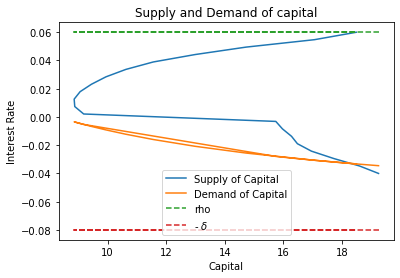

In [20]:
#  Plot the results:

r_space = np.linspace(-delta+0.04,rho,20)

demand = capital_to_r(eapath)

fig, ax = plt.subplots()
ax.plot(eapath,r_space,label='Supply of Capital')
ax.plot(eapath,demand,label='Demand of Capital')
ax.plot(eapath,rho*np.ones(20),'--',label='rho')
ax.plot(eapath,-delta*np.ones(20),'--',label='- $\delta$')
plt.ylabel('Interest Rate')
plt.xlabel('Capital')
plt.title('Supply and Demand of capital')
plt.legend() 
